In [1]:
import wandb
from datetime import datetime

In [2]:
IMAGE_SIZE = 256
batch_size= 16
lr=1e-4
wd=1e-6
model_name="effnet-m"
epochs = 300

In [3]:
wandb_entity='longyi'

wandb.init(project="cervical-spine", entity=wandb_entity, config={
    "model":model_name,
    "batch_size":batch_size,
    "lr" : lr,
    "wd" : wd,
    "image_size" : IMAGE_SIZE
})
wandb.run.name = f'sagittal_{model_name}_boundary_' + datetime.now().strftime("%H%M%S")

wandb: Currently logged in as: longyi. Use `wandb login --relogin` to force relogin


In [4]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from tqdm import tqdm

from PIL import Image, ImageOps

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.io import read_image
import torchvision.transforms as T

import torchvision.transforms.functional as TF
import torchvision.models as models

import albumentations as A
from albumentations.pytorch import ToTensorV2

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [6]:
# DATA_DIR = "/Volumes/SSD970/"
DATA_DIR = "/root/autodl-tmp/cervical_spine/"
IMAGES_DIR = os.path.join(DATA_DIR, "xray_images")

In [7]:
bbox_df = pd.read_csv(os.path.join(DATA_DIR, 'segmentation_sagittal_bbox.csv')).set_index('UID')
print(len(bbox_df))
bbox_df.head()

87


,xmin,ymin,xmax,ymax,aspect
UID,,,,,
1.2.826.0.1.3680043.10633,128.3,167.978082,484.7,614.049315,1.753425
1.2.826.0.1.3680043.10921,196.8,70.400053,439.2,490.541546,1.882354
1.2.826.0.1.3680043.11827,66.5,69.764885,300.5,358.204580,1.954198
1.2.826.0.1.3680043.11988,75.0,124.000000,375.0,697.210000,3.436242
1.2.826.0.1.3680043.12281,46.8,127.733333,493.2,834.933333,2.666667


In [8]:
def get_rectangle_edges_from_pascal_bbox(bbox):
    xmin_top_left, ymin_top_left, xmax_bottom_right, ymax_bottom_right = bbox

    # bottom_left = (xmin_top_left, ymax_bottom_right)
    width = xmax_bottom_right - xmin_top_left
    height = ymin_top_left - ymax_bottom_right

    return xmin_top_left, ymax_bottom_right, width, height

def draw_pascal_voc_bboxes(
        plot_ax,
        bbox,
        get_rectangle_corners_fn=get_rectangle_edges_from_pascal_bbox,
):
    x, y, width, height = get_rectangle_corners_fn(bbox)

    rect_1 = patches.Rectangle(
        (x, y),
        width,
        height,
        linewidth=4,
        edgecolor="black",
        fill=False,
    )
    rect_2 = patches.Rectangle(
        (x, y),
        width,
        height,
        linewidth=2,
        edgecolor="white",
        fill=False,
    )

    # Add the patch to the Axes
    plot_ax.add_patch(rect_1)
    plot_ax.add_patch(rect_2)

def show_image(
        image, bboxes=None, draw_bboxes_fn=draw_pascal_voc_bboxes, figsize=(10, 10), ax=None
):
    if ax is None:  
        fig, ax = plt.subplots(1, figsize=figsize)
    ax.imshow(image)

    if bboxes is not None:
        draw_bboxes_fn(ax, bboxes)

    # plt.show()
    


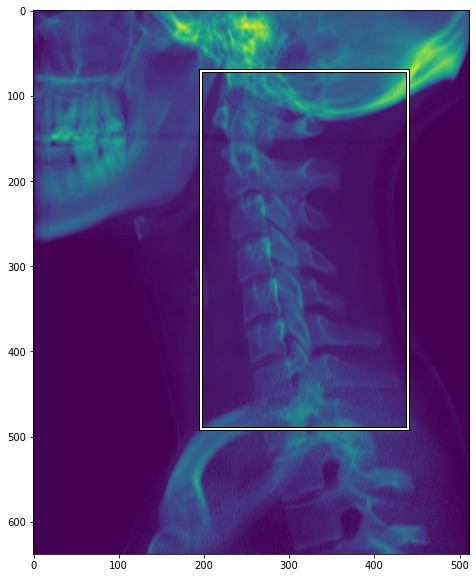

In [9]:
class SagittalBoundaryDataset(Dataset):
    def __init__(self, df, image_dir, transform=None):
        super().__init__()

        self.df = df
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        s = self.df.iloc[idx]
        UID = s.name
        img = Image.open(os.path.join(self.image_dir, UID, "sagittal.jpeg"))
        
        
        label = s[['xmin','ymin','xmax','ymax']].values
        
        
        if self.transform:
            img, label = self.transform(img,  label)

        return img, label

dataset = SagittalBoundaryDataset(bbox_df, IMAGES_DIR)
img, label = dataset[1]
# print(label)
# plt.imshow(img)

show_image(img, label)


tensor(-1.) tensor(1.)
tensor([ 70.3912,  48.0290, 168.9671, 219.4983])
torch.Size([1, 256, 256])


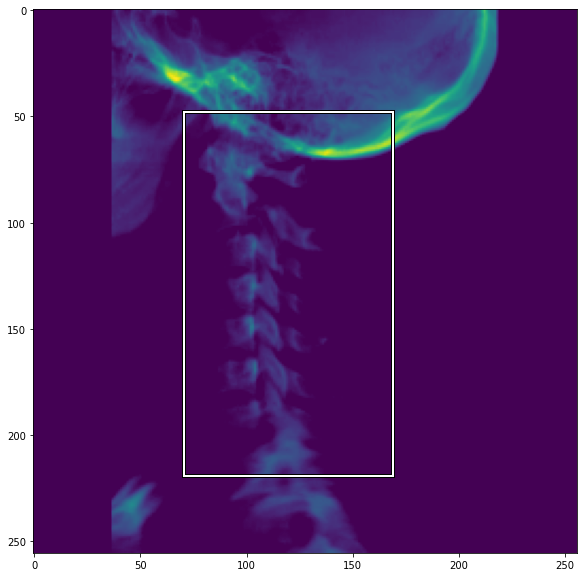

In [10]:

    
class DataTransform(nn.Module):
    def __init__(self, image_size, train=True):
        super().__init__()
        
        self.train = train
        self.image_size = image_size
        
        self.transform = A.Compose([
                A.ShiftScaleRotate(p=0.5),
                A.RandomBrightnessContrast(p=0.5),
                ToTensorV2(p=1),
            ],
            bbox_params=A.BboxParams(format='pascal_voc',min_area=0, min_visibility=0, label_fields=["labels"]),
        )
        
        self.val_transform = ToTensorV2(p=1)
        self.normalize = T.Normalize(255 * 0.5, 255 * 0.5)
        
    def center_crop(self, x, bbox):
        w, h = x.shape[2], x.shape[1]
        
        x = TF.center_crop(x, max(w, h))
        
        if w > h:
            pad = (w - h) // 2
            bbox[[1, 3]] += pad
            return x, bbox
        else:
            pad = (h - w) // 2
            bbox[[0, 2]] += pad
            return x, bbox
            
    
    def resize(self, x, bbox):
        org_size = x.shape[-1]
      
        scale = self.image_size / org_size
        
        x = TF.resize(x, (self.image_size, self.image_size))
      
        bbox = bbox * scale
        return x, bbox
    
    def forward(self, x, label):
        label[0] = max(0, label[0])
        label[1] = max(0, label[1])
        label[2] = min(x.width, label[2])
        label[3] = min(x.height, label[3])
        
        if self.train:
            transformed = self.transform(image=np.asarray(x), bboxes=[label], labels=np.ones(1))
            x, label = transformed["image"], np.asarray(transformed["bboxes"][0])
        else:
            transformed = self.val_transform(image=np.asarray(x))
            x = transformed["image"]
        x, label = self.center_crop(x, label)
        
        x, label = self.resize(x, label)
        
        x = self.normalize(x.float())
        label = torch.tensor(label, dtype=torch.float)
        
        return x, label
    
transform = DataTransform(IMAGE_SIZE, train=True)
dataset = SagittalBoundaryDataset(bbox_df, IMAGES_DIR, transform)
img, label = dataset[15]
print(img.min(), img.max())
print(label)
print(img.shape)
show_image(img.squeeze(), label)

## Model

In [11]:
def get_model():
    if model_name == "effnet-m":
        model = models.efficientnet_v2_m(pretrained=True)
    elif model_name == "effnet-s":
        model = models.efficientnet_v2_s(pretrained=True)
    conv1_weight = model.features[0][0].weight
    conv1_weight = conv1_weight.mean(dim=1).unsqueeze(1)

    model.features[0][0] = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=1, padding='same', bias=False)
    model.features[0][0].weight = nn.Parameter(conv1_weight, requires_grad=True)
    
    model.avgpool = nn.Sequential(
        nn.MaxPool2d(2, 2),
        nn.Flatten()
    )
    # model.classifier[1] = nn.Linear(1280, 4, bias=True)
    model.classifier[1] = nn.Sequential(
        nn.Linear(81920, 1024, bias=True),
        nn.ReLU(),
        nn.Linear(1024, 4, bias=True)
    )
    
    return model




model = get_model()
model = model.to(device)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params

/root/miniconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=EfficientNet_V2_M_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_M_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


136749128

In [12]:
input = torch.randn((2, 1, 256, 256)).to(device)
model(input).shape

torch.Size([2, 4])

In [13]:
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=min(16, batch_size), drop_last=True)

In [14]:
x, y = next(iter(train_loader))
print(x.min(), x.max())
print(y.min(), y.max())
print(y.shape)

tensor(-1.) tensor(1.)
tensor(0.) tensor(239.7133)
torch.Size([16, 4])


In [15]:
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
scaler = torch.cuda.amp.GradScaler(enabled=(device == 'cuda'))
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50, 100, 150, 200], gamma=0.5)

In [16]:
def loss_fn(logits, y):
    pred = logits.sigmoid()
    label = y / IMAGE_SIZE
    
    w = label[:, [2]] - label[:, [0]]
    h = label[:, [3]] - label[:, [1]]
    
    w_loss = F.l1_loss(pred[:, [0, 2]], label[:, [0, 2]], reduction='none') / w
    h_loss = F.l1_loss(pred[:, [1, 3]], label[:, [1, 3]], reduction='none') / h
    
    w_loss = w_loss ** 2
    h_loss = h_loss ** 2
    return w_loss.mean() + h_loss.mean()
    # return F.mse_loss(pred, label)

In [17]:
# model.train()
# train_iter = tqdm(train_loader)
# for i, (x, y) in enumerate(train_iter):
#     x = x.to(device)
#     y = y.to(device)
        
#     logits = model(x)
#     loss = loss_fn(logits, y)
    
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()
    
#     train_iter.set_description(f"loss {loss.item():.4f}")
        

In [18]:

def train_one_epoch(e, model, dataloader):
    model.train()
    train_iter = tqdm(dataloader)
    losses = []
    epoch_iteration = len(dataloader)

    for i, (x, y) in enumerate(train_iter):
        x = x.to(device)
        y = y.to(device)

        with torch.cuda.amp.autocast(device == 'cuda'):
            logits = model(x)
            loss = loss_fn(logits, y)

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.)
        scaler.step(optimizer)
        scaler.update()

        train_iter.set_description(f"t {e} loss {loss.item():.4f}")

        losses.append(loss.item())

        if wandb.run is not None:
            lr_logs = {f"last_lr_{i}": float(v) for i, v in enumerate(scheduler.get_last_lr())}
            wandb.log({
                'train_loss': loss.item(),
                'epoch': e,
                'train_iteration': i + e * epoch_iteration,
                **lr_logs,
            })

        # if i % 10 == 0:
        #     with torch.no_grad():
        #         infer_bad_sample(wandb_log=True)
        #     model.train()

    return np.mean(losses)

In [19]:
def get_inference_input(UID, transform):
    slice_img = Image.open(os.path.join(IMAGES_DIR, UID, f"sagittal.jpeg"))
    label = np.array([1,2,3,4])
    return transform(slice_img, label)

In [20]:
def log_detection_image(image, box, epoch=None, image_key="image"):
    """
    log wandb image
    :param image:
    :param boxes: tensor N x 4, [x0, y0, x1, y1], (0-1) normalized location wrt image W, H
    :param labels: tensor N, [0 - num_classes)
    :param scores: tensor N, [0 - 1]
    :param image_key: key of image, please using same key for same images,
    :return:
    """
    class_labels = {
        0: "box"
    }
    
    
    box_data = [{
            "position": {
                "minX": float(box[0]),
                "minY": float(box[1]),
                "maxX": float(box[2]),
                "maxY": float(box[3])
            },
            "class_id": 0,
        }]
    
    img = wandb.Image(image, boxes={
        "predictions": {
            "box_data": box_data,
            "class_labels": class_labels
        }
    })
    wandb.log({image_key: img, "epoch": epoch})

In [21]:
xray_df = pd.read_csv(os.path.join(DATA_DIR, 'meta_xray.csv')).set_index('UID')
xray_df.head()

UIDs = xray_df.index.unique().values
len(UIDs)

2011

In [22]:
val_df = pd.DataFrame({
    'UID' : UIDs,
    'xmin' : np.ones(len(UIDs)) + 100.,
    'ymin' : np.ones(len(UIDs)) + 100.,
    'xmax' : np.ones(len(UIDs)) + 200.,
    'ymax' : np.ones(len(UIDs)) + 200.,
}).set_index('UID')
val_df.head()

,xmin,ymin,xmax,ymax
UID,,,,
1.2.826.0.1.3680043.10001,101.0,101.0,201.0,201.0
1.2.826.0.1.3680043.10005,101.0,101.0,201.0,201.0
1.2.826.0.1.3680043.10014,101.0,101.0,201.0,201.0
1.2.826.0.1.3680043.10016,101.0,101.0,201.0,201.0
1.2.826.0.1.3680043.10032,101.0,101.0,201.0,201.0


tensor(-1.) tensor(0.9294)
tensor([ 50.5000,  51.0000, 100.5000, 101.0000])
torch.Size([1, 256, 256])


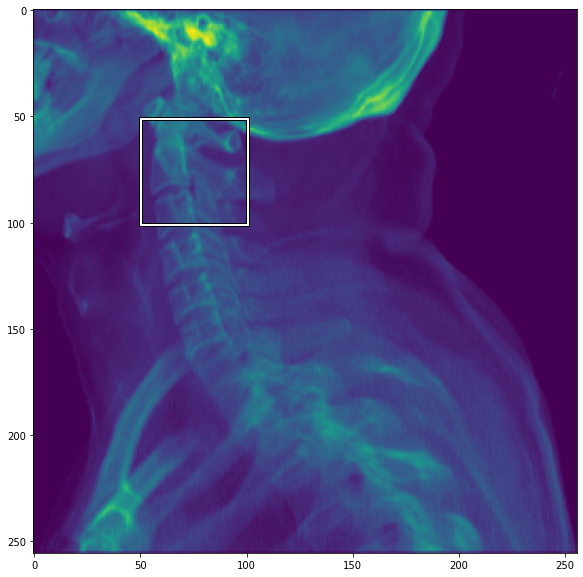

In [23]:
val_transform = DataTransform(IMAGE_SIZE, train=False)
val_dataset = SagittalBoundaryDataset(val_df, IMAGES_DIR, val_transform)
img, label = val_dataset[16]
print(img.min(), img.max())
print(label)
print(img.shape)
show_image(img.squeeze(), label)

In [24]:
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, pin_memory=False, num_workers=min(16, batch_size), drop_last=True)
max_iter = len(val_loader)
print(max_iter)
val_iter = iter(val_loader)

# for i, (x, y) in enumerate(val_iter):
#     pass

125


In [25]:
from torchvision.utils import draw_bounding_boxes, make_grid
def infer_sample(model, val_iter, wandb_log=False):
    model.eval()

    x, y = next(val_iter)

    x = x.to(device)

    logits = model(x)

    prob = logits.sigmoid()
    # print(prob.shape)

    x = x * 0.5 + 0.5
    x = x * 255
    x = x.to(torch.uint8)
    
    if wandb_log is True and wandb.run is not None:
        img_list = []
        for i in range(x.shape[0]):
            img = draw_bounding_boxes(x[i], boxes=prob[[i]] * IMAGE_SIZE, colors='white')
            img_list.append(img)
        img_list = torch.stack(img_list, dim=0)
        img = make_grid(img_list, nrow=4)
        wandb.log({
            'pred_image' : wandb.Image(img.permute(1, 2, 0).cpu().numpy())
        })
            
            
        
    if wandb_log is False:
        _, axs = plt.subplots(len(UIDs) // 4, 4, figsize=(12, 12))
        
        for i in range(x.shape[0]):
            bbox = prob[i].detach().cpu().numpy() * IMAGE_SIZE
            show_image(x[i, 0].detach().cpu().numpy(), bbox, ax=axs[i // 4, i % 4])
        # bbox = prob[0].detach().cpu().numpy() * IMAGE_SIZE
        # show_image(x[0, 0].detach().cpu().numpy(), bbox)
        plt.show()
        
with torch.no_grad():
    infer_sample(model, val_iter, wandb_log=True)

In [26]:
epoch = 0

In [27]:
for e in range(epochs):
    train_one_epoch(epoch, model, train_loader)
    
    with torch.no_grad():
        if e % max_iter == 0:
            val_iter = iter(val_loader)
        infer_sample(model, val_iter, wandb_log=True)
    scheduler.step()
    
    epoch += 1

t 299 loss 0.0015: 100%|██████████| 5/5 [00:04<00:00,  1.11it/s]


In [28]:

state = {
    "model": model.state_dict(),
    "optimizer": optimizer.state_dict(),
    "scheduler": scheduler.state_dict(),
    "epoch": epoch,
}
torch.save(state, os.path.join(DATA_DIR, f'checkpoint/{wandb.run.name}-epoch-{epoch}.pth'))

## infer every sagittal xray image